In [24]:
from __future__ import print_function
import numpy as np
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
import dask.dataframe as dd
import tensorflow as tf
import sys

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNLSTM, CuDNNGRU, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization
from time import time
from keras.layers.advanced_activations import LeakyReLU, PReLU
#from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras import backend as K

#from livelossplot import PlotLossesKeras
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.client import device_lib
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
import keras as ks
import pickle

import pandas_datareader.data as pd_reader
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
#conda install -c delichon pandas_datareader

In [4]:
from platform import python_version
print(python_version())

3.7.1


In [5]:
#pip install hyperas

In [6]:
quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'adj_close','open','high','low','close'] }, ticker = ['PG'], date = { 'gte': '2009-01-01', 'lte': '2019-12-19' })
df = pd_reader.DataReader('PG','yahoo')

In [7]:
from hyperas.distributions import uniform

from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform

### Make sure to edit your stock ticker in def data()

In [ ]:
def data():
    ###maka sure to change the stock ticker here 
    quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
    df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'adj_close','open','high','low','close'] }, ticker = ['PG'], date = { 'gte': '2009-01-01', 'lte': '2019-12-19' })
    df = pd_reader.DataReader('PG','yahoo')
    df = df[['Adj Close','High','Open','Close','Low']] 
    df = df.dropna()
    
    factor_ratio = 0.7
    df1 = df.iloc[:round(len(df)*factor_ratio)]
    df2 = df[round(len(df)*factor_ratio):]
    
    training_set = df1.iloc[:,0:].values
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    
    #train set
    X_train = []
    y_train = []
    for i in range(45, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-45:i])
        y_train.append(training_set_scaled[i,0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
    
    #test set
    y_test = df2.iloc[:,0:1].values

    dataset_total = df.iloc[:,0:]
    inputs = dataset_total[len(dataset_total) - len(df2) -45:].values
    inputs = sc.fit_transform(inputs)

    X_test = []
    for i in range(45, len(inputs)):
        X_test.append(inputs[i-45:i])
    
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
    
    return X_train, y_train, X_test, y_test

In [9]:
X_train, y_train, X_test, y_test = data()

### Things to consider 
1. create_model function: Change epochs to a lower number in the beginning
2. create_model function: Start with lower number of layers - 4 was the best for me 
3. create_model function: The number of hidden layers is still to be tuned manually 
4. create_model function: if you are to add more layers. Make sure that the last layer is always set to (return_sequence=False) 
5. create_model function: you can add more parameters to tune: such as activation function, add more optimizers, or change dropout rate to a range between 0 & 1. 
6. if __name__ == '__main__' function: Make sure notebook_name matches the name of your notebook, otherwise it doesn't run. not sure how it would work on pycharm (you can try to remove this parameter) 
7. if __name__ == '__main__' function: you can change the number of max_eval to a lower number if you want this to run faster. This parameter is similar to a random search, and  will give you different models based on the max_eval number chosen. 3 or 4 should be okay with what I have seen so far. 

**This will take time if you are running it on your local machine**

In [10]:
def create_model(X_train, y_train, X_test, y_test): 
    """
    Model providing function:

    Create Keras model with double curly brackets dropped-in as needed.
    Return value has to be a valid python dictionary with two customary keys:
        - loss: Specify a numeric evaluation metric to be minimized
        - status: Just use STATUS_OK and see hyperopt documentation if not feasible
    The last one is optional, though recommended, namely:
        - model: specify the model just created so that we can later use it again.
    """
      
    model = Sequential()
    model.add(LSTM(units={{choice([100, 200, 300])}}, input_shape=(45,5), return_sequences= True))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= True))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= True))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
    model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    #model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
    #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    #model.add(LSTM(units={{choice([100, 200, 300])}}, return_sequences= False))
    #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    #model.add(LSTM(units={{choice([100, 200, 300])}}))
    #model.add(Dropout(rate={{uniform(0.2, 0.5)}}))
    
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer={{choice(['adam', 'sgd'])}})

    model.summary()

    result = model.fit(X_train, y_train,
              batch_size={{choice([100,50,80,200])}},
              epochs=200, verbose=2)
    #get the highest validation accuracy of the training epochs
    validation_error = np.amin(result.history['loss']) 
    print('Best validation error of epoch:', validation_error)
    return {'loss': -validation_error, 'status': STATUS_OK, 'model': model}

In [11]:
if __name__ == '__main__':
    best_run, best_model = optim.minimize(model=create_model,
                                    data=data,
                                    algo=tpe.suggest,
                                    max_evals=5,
                                    trials=Trials(),
                                    notebook_name='LSTM with Hyperas - Auto Tuning for stock price prediction')
    X_train, Y_train, X_test, Y_test = data()
    print("Evalutation of best performing model:")
    print(best_model)
    print("Best performing model chosen hyper-parameters:")
    print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import quandl
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from tqdm import tqdm
except:
    pass

try:
    import dask.dataframe as dd
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import sys
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers.core import Dense, Activation, Dropout, Flatten
except:
    pass

try:
    from keras.layers.recurrent import LSTM
except:
    pass

try:
    from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout, CuDNNLSTM, CuDNNGRU, Conv2D, MaxPooling2D
except:
    pass

try:
    from keras.callbacks import EarlyStopping, TensorBoard, Model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"                              
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 45, 200)           164800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 45, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 45, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 45, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 45, 2

 - 5s - loss: 0.0036                               

Epoch 56/200                                       
 - 5s - loss: 0.0037                               

Epoch 57/200                                       
 - 5s - loss: 0.0036                               

Epoch 58/200                                       
 - 5s - loss: 0.0036                               

Epoch 59/200                                       
 - 5s - loss: 0.0039                               

Epoch 60/200                                       
 - 5s - loss: 0.0035                               

Epoch 61/200                                       
 - 5s - loss: 0.0033                               

Epoch 62/200                                       
 - 5s - loss: 0.0032                               

Epoch 63/200                                       
 - 5s - loss: 0.0031                               

Epoch 64/200                                       
 - 5s - loss: 0.0030                               

Ep

 - 5s - loss: 0.0026                               

Epoch 134/200                                      
 - 5s - loss: 0.0027                               

Epoch 135/200                                      
 - 5s - loss: 0.0023                               

Epoch 136/200                                      
 - 5s - loss: 0.0019                               

Epoch 137/200                                      
 - 5s - loss: 0.0019                               

Epoch 138/200                                      
 - 5s - loss: 0.0018                               

Epoch 139/200                                      
 - 5s - loss: 0.0020                               

Epoch 140/200                                      
 - 6s - loss: 0.0018                               

Epoch 141/200                                      
 - 6s - loss: 0.0020                               

Epoch 142/200                                      
 - 6s - loss: 0.0018                               

Ep

_________________________________________________________________                   
lstm_7 (LSTM)                (None, 45, 300)           601200                       
_________________________________________________________________                   
dropout_7 (Dropout)          (None, 45, 300)           0                            
_________________________________________________________________                   
lstm_8 (LSTM)                (None, 100)               160400                       
_________________________________________________________________                   
dropout_8 (Dropout)          (None, 100)               0                            
_________________________________________________________________                   
dense_3 (Dense)              (None, 25)                2525                         
_________________________________________________________________                   
dense_4 (Dense)              (None, 1)                 26        

Epoch 40/200                                                                        
 - 4s - loss: 0.0054                                                                

Epoch 41/200                                                                        
 - 4s - loss: 0.0049                                                                

Epoch 42/200                                                                        
 - 4s - loss: 0.0046                                                                

Epoch 43/200                                                                        
 - 4s - loss: 0.0046                                                                

Epoch 44/200                                                                        
 - 4s - loss: 0.0044                                                                

Epoch 45/200                                                                        
 - 4s - loss: 0.0043                                        

 - 5s - loss: 0.0039                                                                

Epoch 88/200                                                                        
 - 5s - loss: 0.0036                                                                

Epoch 89/200                                                                        
 - 4s - loss: 0.0033                                                                

Epoch 90/200                                                                        
 - 4s - loss: 0.0034                                                                

Epoch 91/200                                                                        
 - 4s - loss: 0.0034                                                                

Epoch 92/200                                                                        
 - 5s - loss: 0.0037                                                                

Epoch 93/200                                               

Epoch 135/200                                                                       
 - 4s - loss: 0.0035                                                                

Epoch 136/200                                                                       
 - 4s - loss: 0.0036                                                                

Epoch 137/200                                                                       
 - 4s - loss: 0.0033                                                                

Epoch 138/200                                                                       
 - 4s - loss: 0.0033                                                                

Epoch 139/200                                                                       
 - 4s - loss: 0.0031                                                                

Epoch 140/200                                                                       
 - 4s - loss: 0.0029                                        

 - 4s - loss: 0.0022                                                                

Epoch 183/200                                                                       
 - 5s - loss: 0.0022                                                                

Epoch 184/200                                                                       
 - 5s - loss: 0.0022                                                                

Epoch 185/200                                                                       
 - 4s - loss: 0.0023                                                                

Epoch 186/200                                                                       
 - 4s - loss: 0.0023                                                                

Epoch 187/200                                                                       
 - 4s - loss: 0.0024                                                                

Epoch 188/200                                              

 - 4s - loss: 0.0057                                                             

Epoch 17/200                                                                     
 - 4s - loss: 0.0053                                                             

Epoch 18/200                                                                     
 - 4s - loss: 0.0060                                                             

Epoch 19/200                                                                     
 - 4s - loss: 0.0062                                                             

Epoch 20/200                                                                     
 - 4s - loss: 0.0051                                                             

Epoch 21/200                                                                     
 - 4s - loss: 0.0060                                                             

Epoch 22/200                                                                     
 - 4s - lo

Epoch 66/200                                                                     
 - 4s - loss: 0.0027                                                             

Epoch 67/200                                                                     
 - 4s - loss: 0.0028                                                             

Epoch 68/200                                                                     
 - 4s - loss: 0.0026                                                             

Epoch 69/200                                                                     
 - 4s - loss: 0.0026                                                             

Epoch 70/200                                                                     
 - 4s - loss: 0.0031                                                             

Epoch 71/200                                                                     
 - 4s - loss: 0.0028                                                             

Epoch 72/2

 - 4s - loss: 0.0024                                                             

Epoch 116/200                                                                    
 - 4s - loss: 0.0020                                                             

Epoch 117/200                                                                    
 - 4s - loss: 0.0019                                                             

Epoch 118/200                                                                    
 - 4s - loss: 0.0019                                                             

Epoch 119/200                                                                    
 - 4s - loss: 0.0020                                                             

Epoch 120/200                                                                    
 - 4s - loss: 0.0020                                                             

Epoch 121/200                                                                    
 - 4s - lo

Epoch 165/200                                                                    
 - 4s - loss: 0.0017                                                             

Epoch 166/200                                                                    
 - 4s - loss: 0.0015                                                             

Epoch 167/200                                                                    
 - 4s - loss: 0.0016                                                             

Epoch 168/200                                                                    
 - 4s - loss: 0.0017                                                             

Epoch 169/200                                                                    
 - 4s - loss: 0.0016                                                             

Epoch 170/200                                                                    
 - 4s - loss: 0.0017                                                             

Epoch 171/

Trainable params: 1,414,651                                                      
Non-trainable params: 0                                                          
_________________________________________________________________                
Epoch 1/200                                                                      
 - 9s - loss: 0.1955                                                             

Epoch 2/200                                                                      
 - 5s - loss: 0.0435                                                             

Epoch 3/200                                                                      
 - 5s - loss: 0.0276                                                             

Epoch 4/200                                                                      
 - 5s - loss: 0.0205                                                             

Epoch 5/200                                                                      
 - 5s - loss

Epoch 49/200                                                                     
 - 5s - loss: 0.0031                                                             

Epoch 50/200                                                                     
 - 5s - loss: 0.0031                                                             

Epoch 51/200                                                                     
 - 5s - loss: 0.0032                                                             

Epoch 52/200                                                                     
 - 5s - loss: 0.0030                                                             

Epoch 53/200                                                                     
 - 5s - loss: 0.0032                                                             

Epoch 54/200                                                                     
 - 5s - loss: 0.0030                                                             

Epoch 55/2

 - 5s - loss: 0.0021                                                             

Epoch 99/200                                                                     
 - 5s - loss: 0.0020                                                             

Epoch 100/200                                                                    
 - 5s - loss: 0.0021                                                             

Epoch 101/200                                                                    
 - 5s - loss: 0.0021                                                             

Epoch 102/200                                                                    
 - 5s - loss: 0.0019                                                             

Epoch 103/200                                                                    
 - 5s - loss: 0.0020                                                             

Epoch 104/200                                                                    
 - 5s - lo

Epoch 148/200                                                                    
 - 5s - loss: 0.0017                                                             

Epoch 149/200                                                                    
 - 5s - loss: 0.0017                                                             

Epoch 150/200                                                                    
 - 5s - loss: 0.0015                                                             

Epoch 151/200                                                                    
 - 5s - loss: 0.0015                                                             

Epoch 152/200                                                                    
 - 5s - loss: 0.0016                                                             

Epoch 153/200                                                                    
 - 5s - loss: 0.0017                                                             

Epoch 154/

Epoch 197/200                                                                      
 - 5s - loss: 0.0012                                                               

Epoch 198/200                                                                      
 - 5s - loss: 0.0012                                                               

Epoch 199/200                                                                      
 - 5s - loss: 0.0013                                                               

Epoch 200/200                                                                      
 - 5s - loss: 0.0016                                                               

Best validation error of epoch:                                                    
0.0012002428279057546                                                              
Model: "sequential_5"                                                              
_________________________________________________________________       

 - 4s - loss: 0.0049                                                               

Epoch 31/200                                                                       
 - 4s - loss: 0.0046                                                               

Epoch 32/200                                                                       
 - 4s - loss: 0.0042                                                               

Epoch 33/200                                                                       
 - 4s - loss: 0.0041                                                               

Epoch 34/200                                                                       
 - 4s - loss: 0.0044                                                               

Epoch 35/200                                                                       
 - 4s - loss: 0.0046                                                               

Epoch 36/200                                                          

 - 4s - loss: 0.0035                                                               

Epoch 79/200                                                                       
 - 5s - loss: 0.0028                                                               

Epoch 80/200                                                                       
 - 5s - loss: 0.0030                                                               

Epoch 81/200                                                                       
 - 4s - loss: 0.0030                                                               

Epoch 82/200                                                                       
 - 4s - loss: 0.0035                                                               

Epoch 83/200                                                                       
 - 4s - loss: 0.0033                                                               

Epoch 84/200                                                          

 - 5s - loss: 0.0024                                                               

Epoch 127/200                                                                      
 - 5s - loss: 0.0028                                                               

Epoch 128/200                                                                      
 - 5s - loss: 0.0027                                                               

Epoch 129/200                                                                      
 - 5s - loss: 0.0032                                                               

Epoch 130/200                                                                      
 - 5s - loss: 0.0025                                                               

Epoch 131/200                                                                      
 - 5s - loss: 0.0027                                                               

Epoch 132/200                                                         

 - 5s - loss: 0.0018                                                               

Epoch 175/200                                                                      
 - 5s - loss: 0.0020                                                               

Epoch 176/200                                                                      
 - 5s - loss: 0.0019                                                               

Epoch 177/200                                                                      
 - 4s - loss: 0.0019                                                               

Epoch 178/200                                                                      
 - 4s - loss: 0.0021                                                               

Epoch 179/200                                                                      
 - 5s - loss: 0.0021                                                               

Epoch 180/200                                                         

In [15]:
best_run

{'batch_size': 3,
 'optimizer': 0,
 'rate': 0.46691312979215505,
 'rate_1': 0.3638449959182119,
 'rate_2': 0.21725919156120255,
 'rate_3': 0.2471488054775952,
 'rate_4': 0.36327262759430057,
 'rate_5': 0.3302123784264954,
 'rate_6': 0.4092522658655936,
 'units': 2,
 'units_1': 1,
 'units_2': 2,
 'units_3': 0,
 'units_4': 1,
 'units_5': 2,
 'units_6': 0}

In [16]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 45, 300)           367200    
_________________________________________________________________
dropout_5 (Dropout)          (None, 45, 300)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 45, 200)           400800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 45, 200)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 45, 300)           601200    
_________________________________________________________________
dropout_7 (Dropout)          (None, 45, 300)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)              

## Make sure to edit your stock ticker again in the next cell

In [17]:
##maka sure to change the stock ticker here 
quandl.ApiConfig.api_key = "uRMo697HgMj91ZZZa2_v"
df = quandl.get_table('WIKI/PRICES', qopts = { 'columns': ['ticker', 'date', 'adj_close','open','high','low','close'] }, ticker = ['PG'], date = { 'gte': '2009-01-01', 'lte': '2019-12-19' })
df = pd_reader.DataReader('PG','yahoo')
df = df[['Adj Close','High','Open','Close','Low']]
df = df.dropna()
    
factor_ratio = 0.7
df1 = df.iloc[:round(len(df)*factor_ratio)]
df2 = df[round(len(df)*factor_ratio):]
    
training_set = df1.iloc[:,0:].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)


In [18]:
real_stock_price = df2.iloc[:,0:1].values

dataset_total = df.iloc[:,0:]

inputs = dataset_total[len(dataset_total) - len(df2) -45:].values
#inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)

X_test = []
for i in range(45, len(inputs)):
    X_test.append(inputs[i-45:i])

In [19]:
X_test = np.array(X_test)

In [20]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))
X_test.shape

(377, 45, 5)

In [21]:
predicted_stock_price= best_model.predict(X_test)
sc.fit_transform(real_stock_price)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price = pd.DataFrame(predicted_stock_price,columns=['adj_close'])
predicted_stock_price.reset_index(inplace=True)
predicted_stock_price = predicted_stock_price[['adj_close']]
data_test = df[round(len(df)*factor_ratio):]
data_test.reset_index(inplace=True)
data_test = data_test[["Date"]]

final = pd.merge(data_test, predicted_stock_price, left_index=True, right_index=True)
final.head()

,Date,adj_close
0,2018-07-17,82.248886
1,2018-07-18,82.341217
2,2018-07-19,82.454590
3,2018-07-20,82.512016
4,2018-07-23,82.482262


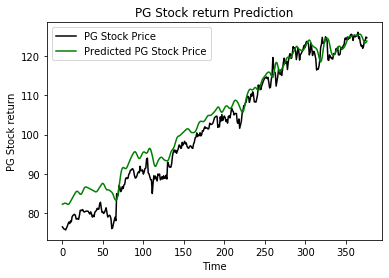

In [22]:
plt.plot(real_stock_price, color = 'black', label = 'PG Stock Price')
plt.plot(predicted_stock_price['adj_close'], color = 'green', label = 'Predicted PG Stock Price')
plt.title('PG Stock return Prediction')
plt.xlabel('Time')
plt.ylabel('PG Stock return')
plt.legend()
plt.show()